In [127]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import confusion_matrix, accuracy_score

Конфиг

In [128]:
class Config:
    DATA_DIR = './dataset'
    METADATA_PATH = os.path.join(DATA_DIR, 'metadata.csv')
    BATCH_SIZE = 8
    EPOCHS = 20
    LR = 0.001
    IMG_SIZE = (256, 256)
    DEVICE = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
    NUM_CLASSES = 2  # фон и дороги

Датасет и загрузчики

In [129]:
class RoadsDataset(Dataset):
    def __init__(self, metadata_df, base_dir, transform=None, target_size=(256, 256)):
        self.metadata = metadata_df
        self.base_dir = base_dir
        self.transform = transform
        self.target_size = target_size

    def __len__(self):
        return len(self.metadata)
        
    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]
        img_path = self._resolve_path(row['tiff_image_path'])
        label_path = self._resolve_path(row['tif_label_path'], is_label=True)
        
        image = Image.open(img_path).convert('RGB')
        label = Image.open(label_path).convert('RGB')
        
        # Ресайзим и изображение и маску
        resize_transform = transforms.Resize(self.target_size)
        image = resize_transform(image)
        label = resize_transform(label)
        
        # Преобразование в бинарную маску
        label_np = np.array(label)
        mask = np.zeros(label_np.shape[:2], dtype=np.uint8)
        mask[np.all(label_np == [255, 255, 255], axis=-1)] = 1
        
        if self.transform:
            image = self.transform(image)
            mask = torch.from_numpy(mask).long()
        
        return image, mask
    
    def _resolve_path(self, rel_path, is_label=False):
        path = os.path.join(self.base_dir, rel_path)
        if os.path.exists(path):
            return path
        
        # Пробуем альтернативные расширения
        if is_label:
            alt_path = path.replace('.tif', '.tiff')
        else:
            alt_path = path.replace('.tiff', '.tif')
            
        if os.path.exists(alt_path):
            return alt_path
        
        raise FileNotFoundError(f"Neither {path} nor {alt_path} found")

U-Net

In [130]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [131]:
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

In [132]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [133]:
class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
        
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = nn.functional.pad(x1, [diffX // 2, diffX - diffX // 2,
                                    diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [134]:
class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=2, bilinear=True, output_size=(256, 256)):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        self.output_size = output_size

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024 // (2 if bilinear else 1))
        self.up1 = Up(1024, 512 // (2 if bilinear else 1), bilinear)
        self.up2 = Up(512, 256 // (2 if bilinear else 1), bilinear)
        self.up3 = Up(256, 128 // (2 if bilinear else 1), bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)

        if logits.shape[2:] != self.output_size:
            logits = F.interpolate(logits, size=self.output_size, mode='bilinear', align_corners=True)

        return logits

Метрики

In [135]:
def calculate_iou(preds, labels):
    labels_resized = F.interpolate(labels.unsqueeze(1).float(), 
                                 size=preds.shape[2:], 
                                 mode='nearest').squeeze(1).long()
    
    preds = torch.argmax(preds, dim=1)
    intersection = (preds & labels_resized).float().sum()
    union = (preds | labels_resized).float().sum()
    return (intersection + 1e-6) / (union + 1e-6)


def calculate_metrics(preds, labels):
    preds = torch.argmax(preds, dim=1)
    tn, fp, fn, tp = confusion_matrix(labels.cpu().numpy().flatten(),
                                    preds.cpu().numpy().flatten(),
                                    labels=[0, 1]).ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    return accuracy, precision, recall

Инициализация

In [136]:
def init_datasets():
    metadata = pd.read_csv(Config.METADATA_PATH)
    
    transform = transforms.Compose([
        transforms.Resize(Config.IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    train_df = metadata[metadata['split'] == 'train']
    val_df = metadata[metadata['split'] == 'val']
    test_df = metadata[metadata['split'] == 'test']
    
    train_dataset = RoadsDataset(train_df, Config.DATA_DIR, transform, Config.IMG_SIZE)
    val_dataset = RoadsDataset(val_df, Config.DATA_DIR, transform, Config.IMG_SIZE)
    test_dataset = RoadsDataset(test_df, Config.DATA_DIR, transform, Config.IMG_SIZE)
    
    return (
        train_dataset,
        val_dataset,
        test_dataset,
        DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True),
        DataLoader(val_dataset, batch_size=Config.BATCH_SIZE),
        DataLoader(test_dataset, batch_size=Config.BATCH_SIZE)
    )

Обучение и оценка

In [137]:
def train_model():
    # Инициализация
    (train_dataset, val_dataset, test_dataset,
     train_loader, val_loader, test_loader) = init_datasets()
    
    Config.IMG_SIZE = (256, 256)  # Желаемый размер изображений
    model = UNet(output_size=Config.IMG_SIZE).to(Config.DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=Config.LR)
    
    # История для графиков
    history = {
        'train_loss': [], 'val_loss': [],
        'train_iou': [], 'val_iou': [],
        'train_acc': [], 'val_acc': [],
        'test_metrics': None
    }
    
    # Обучение
    for epoch in range(Config.EPOCHS):
        model.train()
        epoch_train_loss, epoch_train_iou, epoch_train_acc = 0, 0, 0
        
        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{Config.EPOCHS} [Train]"):
            images, masks = images.to(Config.DEVICE), masks.to(Config.DEVICE)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            # Метрики
            iou = calculate_iou(outputs, masks)
            acc, _, _ = calculate_metrics(outputs, masks)
            
            epoch_train_loss += loss.item()
            epoch_train_iou += iou.item()
            epoch_train_acc += acc
        
        # Валидация
        model.eval()
        epoch_val_loss, epoch_val_iou, epoch_val_acc = 0, 0, 0
        
        with torch.no_grad():
            for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{Config.EPOCHS} [Val]"):
                images, masks = images.to(Config.DEVICE), masks.to(Config.DEVICE)
                outputs = model(images)
                
                loss = criterion(outputs, masks)
                iou = calculate_iou(outputs, masks)
                acc, _, _ = calculate_metrics(outputs, masks)
                
                epoch_val_loss += loss.item()
                epoch_val_iou += iou.item()
                epoch_val_acc += acc
        
        # Сохранение метрик
        history['train_loss'].append(epoch_train_loss / len(train_loader))
        history['val_loss'].append(epoch_val_loss / len(val_loader))
        history['train_iou'].append(epoch_train_iou / len(train_loader))
        history['val_iou'].append(epoch_val_iou / len(val_loader))
        history['train_acc'].append(epoch_train_acc / len(train_loader))
        history['val_acc'].append(epoch_val_acc / len(val_loader))
        
        print(f"\nEpoch {epoch+1}/{Config.EPOCHS}:")
        print(f"Train Loss: {history['train_loss'][-1]:.4f} | Val Loss: {history['val_loss'][-1]:.4f}")
        print(f"Train IoU: {history['train_iou'][-1]:.4f} | Val IoU: {history['val_iou'][-1]:.4f}")
        print(f"Train Acc: {history['train_acc'][-1]:.4f} | Val Acc: {history['val_acc'][-1]:.4f}")
    
    # Тестирование
    model.eval()
    test_loss, test_iou, test_acc, test_prec, test_rec = 0, 0, 0, 0, 0
    
    with torch.no_grad():
        for images, masks in tqdm(test_loader, desc="Testing"):
            images, masks = images.to(Config.DEVICE), masks.to(Config.DEVICE)
            outputs = model(images)
            
            test_loss += criterion(outputs, masks).item()
            test_iou += calculate_iou(outputs, masks).item()
            
            acc, prec, rec = calculate_metrics(outputs, masks)
            test_acc += acc
            test_prec += prec
            test_rec += rec
    
    test_loss /= len(test_loader)
    test_iou /= len(test_loader)
    test_acc /= len(test_loader)
    test_prec /= len(test_loader)
    test_rec /= len(test_loader)
    
    history['test_metrics'] = {
        'loss': test_loss,
        'iou': test_iou,
        'accuracy': test_acc,
        'precision': test_prec,
        'recall': test_rec
    }
    
    print("\nTest Results:")
    print(f"Loss: {test_loss:.4f} | IoU: {test_iou:.4f}")
    print(f"Accuracy: {test_acc:.4f} | Precision: {test_prec:.4f} | Recall: {test_rec:.4f}")
    
    return model, history

Визуализация результатов

In [138]:
def plot_results(history):
    plt.figure(figsize=(18, 12))
    
    # График потерь
    plt.subplot(2, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # График IoU
    plt.subplot(2, 2, 2)
    plt.plot(history['train_iou'], label='Train IoU')
    plt.plot(history['val_iou'], label='Validation IoU')
    plt.title('Training and Validation IoU')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend()
    
    # График точности
    plt.subplot(2, 2, 3)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Тестовые метрики
    plt.subplot(2, 2, 4)
    test_metrics = history['test_metrics']
    metrics = ['Accuracy', 'Precision', 'Recall', 'IoU']
    values = [test_metrics['accuracy'], test_metrics['precision'], 
              test_metrics['recall'], test_metrics['iou']]
    
    plt.bar(metrics, values)
    plt.title('Test Metrics')
    plt.ylabel('Score')
    
    plt.tight_layout()
    plt.show()


Using device: cuda:1


Epoch 1/20 [Val]: 100%|██████████| 2/2 [00:00<00:00,  2.88it/s]



Epoch 1/20:
Train Loss: 0.0569 | Val Loss: 0.0096
Train IoU: 0.0576 | Val IoU: 0.0000
Train Acc: 0.9986 | Val Acc: 1.0000


Epoch 2/20 [Val]: 100%|██████████| 2/2 [00:00<00:00,  2.50it/s]



Epoch 2/20:
Train Loss: 0.0050 | Val Loss: 0.0029
Train IoU: 0.0791 | Val IoU: 0.0000
Train Acc: 1.0000 | Val Acc: 1.0000


Epoch 3/20 [Val]: 100%|██████████| 2/2 [00:00<00:00,  2.94it/s]



Epoch 3/20:
Train Loss: 0.0021 | Val Loss: 0.0015
Train IoU: 0.1295 | Val IoU: 0.0000
Train Acc: 1.0000 | Val Acc: 1.0000


Epoch 4/20 [Val]: 100%|██████████| 2/2 [00:00<00:00,  2.90it/s]



Epoch 4/20:
Train Loss: 0.0013 | Val Loss: 0.0010
Train IoU: 0.0791 | Val IoU: 0.0000
Train Acc: 1.0000 | Val Acc: 1.0000


Epoch 5/20 [Val]: 100%|██████████| 2/2 [00:00<00:00,  2.90it/s]



Epoch 5/20:
Train Loss: 0.0009 | Val Loss: 0.0008
Train IoU: 0.0791 | Val IoU: 0.0000
Train Acc: 1.0000 | Val Acc: 1.0000


Epoch 6/20 [Val]: 100%|██████████| 2/2 [00:00<00:00,  2.89it/s]



Epoch 6/20:
Train Loss: 0.0007 | Val Loss: 0.0006
Train IoU: 0.0576 | Val IoU: 0.0000
Train Acc: 1.0000 | Val Acc: 1.0000


Epoch 7/20 [Val]: 100%|██████████| 2/2 [00:00<00:00,  2.92it/s]



Epoch 7/20:
Train Loss: 0.0006 | Val Loss: 0.0005
Train IoU: 0.0791 | Val IoU: 0.0000
Train Acc: 1.0000 | Val Acc: 1.0000


Epoch 8/20 [Val]: 100%|██████████| 2/2 [00:00<00:00,  2.88it/s]



Epoch 8/20:
Train Loss: 0.0005 | Val Loss: 0.0004
Train IoU: 0.0863 | Val IoU: 0.0000
Train Acc: 1.0000 | Val Acc: 1.0000


Epoch 9/20 [Val]: 100%|██████████| 2/2 [00:00<00:00,  2.96it/s]



Epoch 9/20:
Train Loss: 0.0005 | Val Loss: 0.0004
Train IoU: 0.0576 | Val IoU: 0.0000
Train Acc: 1.0000 | Val Acc: 1.0000


Epoch 10/20 [Val]: 100%|██████████| 2/2 [00:00<00:00,  2.89it/s]



Epoch 10/20:
Train Loss: 0.0004 | Val Loss: 0.0004
Train IoU: 0.1007 | Val IoU: 0.0000
Train Acc: 1.0000 | Val Acc: 1.0000


Epoch 11/20 [Val]: 100%|██████████| 2/2 [00:00<00:00,  2.89it/s]



Epoch 11/20:
Train Loss: 0.0004 | Val Loss: 0.0003
Train IoU: 0.0791 | Val IoU: 0.0000
Train Acc: 1.0000 | Val Acc: 1.0000


Epoch 12/20 [Val]: 100%|██████████| 2/2 [00:00<00:00,  2.92it/s]



Epoch 12/20:
Train Loss: 0.0004 | Val Loss: 0.0003
Train IoU: 0.0791 | Val IoU: 0.0000
Train Acc: 1.0000 | Val Acc: 1.0000


Epoch 13/20 [Val]: 100%|██████████| 2/2 [00:00<00:00,  2.97it/s]



Epoch 13/20:
Train Loss: 0.0004 | Val Loss: 0.0003
Train IoU: 0.0719 | Val IoU: 0.0000
Train Acc: 1.0000 | Val Acc: 1.0000


Epoch 14/20 [Val]: 100%|██████████| 2/2 [00:00<00:00,  2.93it/s]



Epoch 14/20:
Train Loss: 0.0004 | Val Loss: 0.0003
Train IoU: 0.0863 | Val IoU: 0.0000
Train Acc: 1.0000 | Val Acc: 1.0000


Epoch 15/20 [Val]: 100%|██████████| 2/2 [00:00<00:00,  2.91it/s]



Epoch 15/20:
Train Loss: 0.0004 | Val Loss: 0.0003
Train IoU: 0.0935 | Val IoU: 0.0000
Train Acc: 1.0000 | Val Acc: 1.0000


Epoch 16/20 [Val]: 100%|██████████| 2/2 [00:00<00:00,  2.90it/s]



Epoch 16/20:
Train Loss: 0.0003 | Val Loss: 0.0003
Train IoU: 0.1007 | Val IoU: 0.0000
Train Acc: 1.0000 | Val Acc: 1.0000


Epoch 17/20 [Val]: 100%|██████████| 2/2 [00:00<00:00,  2.88it/s]



Epoch 17/20:
Train Loss: 0.0003 | Val Loss: 0.0003
Train IoU: 0.0791 | Val IoU: 0.0000
Train Acc: 1.0000 | Val Acc: 1.0000


Epoch 18/20 [Val]: 100%|██████████| 2/2 [00:00<00:00,  2.92it/s]



Epoch 18/20:
Train Loss: 0.0003 | Val Loss: 0.0003
Train IoU: 0.0863 | Val IoU: 0.0000
Train Acc: 1.0000 | Val Acc: 1.0000


Epoch 19/20 [Val]: 100%|██████████| 2/2 [00:00<00:00,  2.92it/s]



Epoch 19/20:
Train Loss: 0.0003 | Val Loss: 0.0003
Train IoU: 0.1151 | Val IoU: 0.0000
Train Acc: 1.0000 | Val Acc: 1.0000


Epoch 20/20 [Val]: 100%|██████████| 2/2 [00:00<00:00,  2.91it/s]



Epoch 20/20:
Train Loss: 0.0003 | Val Loss: 0.0003
Train IoU: 0.0719 | Val IoU: 0.0000
Train Acc: 1.0000 | Val Acc: 1.0000


Testing: 100%|██████████| 7/7 [00:02<00:00,  2.88it/s]



Test Results:
Loss: 0.0002 | IoU: 0.2857
Accuracy: 1.0000 | Precision: 0.0000 | Recall: 0.0000


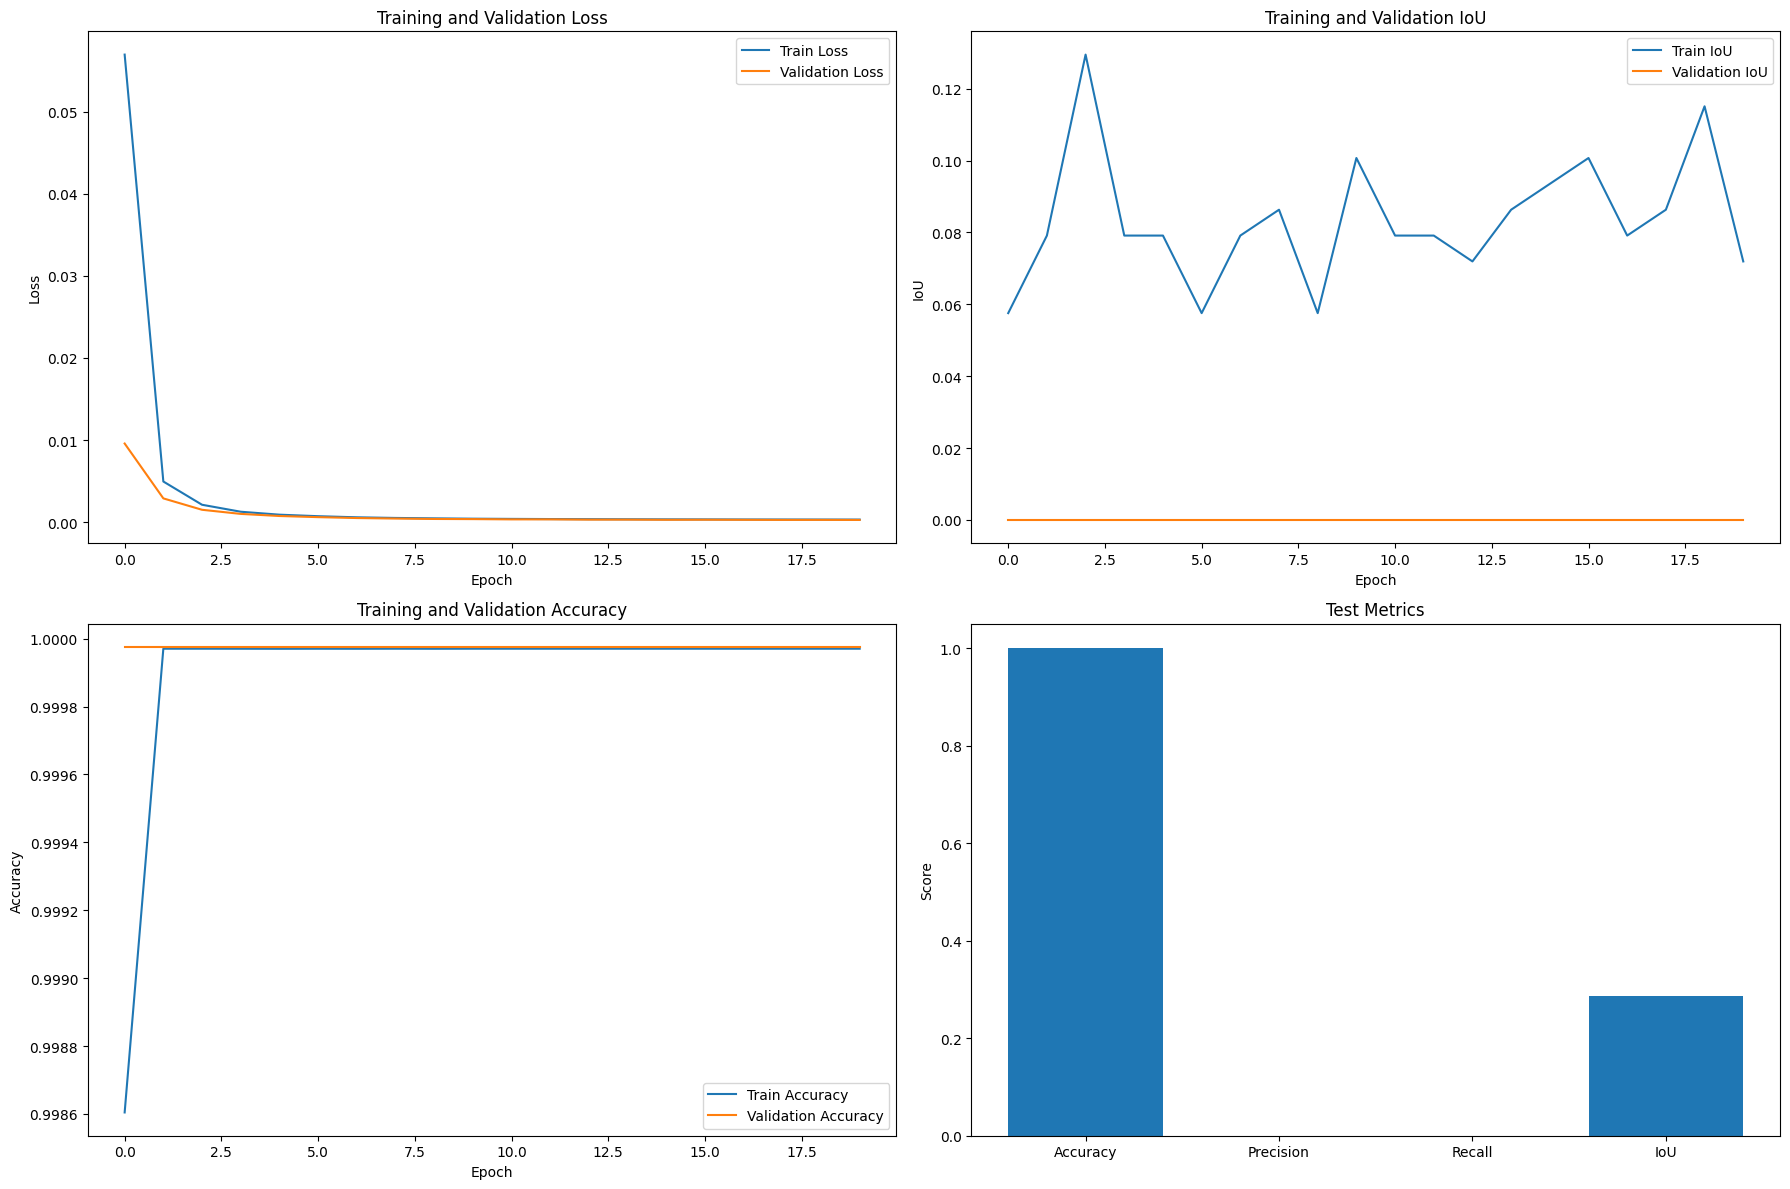

Model saved successfully


In [139]:
print(f"Using device: {Config.DEVICE}")
model, history = train_model()
plot_results(history)
    
# Сохранение модели
torch.save(model.state_dict(), 'road_segmentation_unet.pth')
print("Model saved successfully")